# Days To Fund Prediction

In [22]:
import os
os.chdir('/root/kiva_crowdfunding')

In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from src.merge_worldbank import load_data
from src.preprocessing import drop_col, classify_economy, has_female_borrower
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns

## Dataset

In [31]:
loan = pd.read_csv('data/raw/kiva_loans.csv')
df = loan.drop(columns=['id', 'activity', 'use', 'country_code', 'country', 'region', 'currency', 'partner_id', 'disbursed_time', 'tags', 'date'])
df.head()


,funded_amount,loan_amount,sector,posted_time,funded_time,term_in_months,lender_count,borrower_genders,repayment_interval
0,300.0,300.0,Food,2014-01-01 06:12:39+00:00,2014-01-02 10:06:32+00:00,12.0,12,female,irregular
1,575.0,575.0,Transportation,2014-01-01 06:51:08+00:00,2014-01-02 09:17:23+00:00,11.0,14,"female, female",irregular
2,150.0,150.0,Transportation,2014-01-01 09:58:07+00:00,2014-01-01 16:01:36+00:00,43.0,6,female,bullet
3,200.0,200.0,Arts,2014-01-01 08:03:11+00:00,2014-01-01 13:00:00+00:00,11.0,8,female,irregular
4,400.0,400.0,Food,2014-01-01 11:53:19+00:00,2014-01-01 19:18:51+00:00,14.0,16,female,monthly


## Target Variable

In [32]:
df['funded_time'] = pd.to_datetime(df['funded_time'])
df['posted_time'] = pd.to_datetime(df['posted_time'])
df["funding_time"] = (df['funded_time'] - df['posted_time']).dt.total_seconds() / (3600 * 24)

## Preprocessing

### Numerical Varibles

In [33]:
df['funded_amount_log'] = np.log1p(df['funded_amount'])
df['loan_amount_log'] = np.log1p(df['loan_amount'])

scaler = StandardScaler()
numerical_cols = ['funded_amount_log', 'loan_amount_log']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### Categorical Variables 

In [34]:
# # Categorical Encoding
df = has_female_borrower(df)

categorical_cols = ['sector', 'repayment_interval']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

### Dropping Rest

In [35]:
df = df.drop(columns=['funded_amount', 'loan_amount', 'posted_time', 'funded_time', 'borrower_genders'])
df = df.dropna()

## Train Test Split

In [ ]:
X = df.drop(columns=['funding_time'])
y = np.log1p(df['funding_time']) 

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building

In [58]:
param_grid = {
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

model = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 6],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

## Prediction

In [59]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation

In [60]:
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 7.418846696984734


In [61]:
print("R² Score:", r2_score(y_test, y_pred))

R² Score: 0.42517244765692064


## Feature Importance

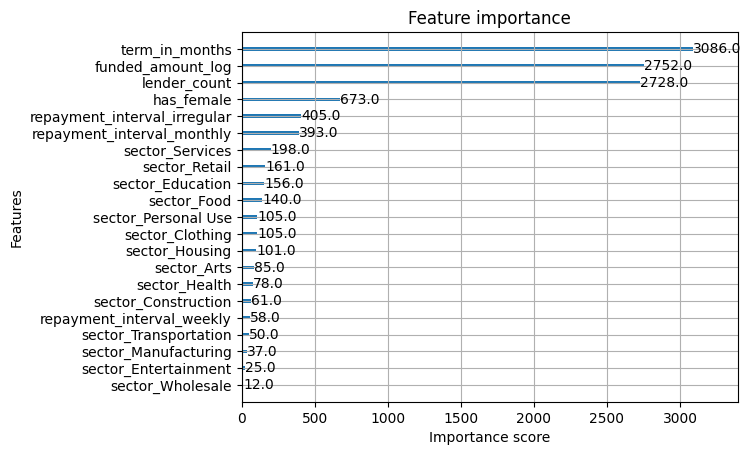

In [63]:
plot_importance(best_model)
plt.show()